In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import nltk
import string

# Using AFINN library - pip install afinn
# Source can be found at https://github.com/fnielsen/afinn
from afinn import Afinn

# Load the punkt model
#nltk.download()

size_afinn = 2477


In [3]:
df = pd.read_pickle('data.pickle')

afinn = Afinn()

afinn_scores = [afinn.score(text) for text in df.Utterance]

df['afinn'] = afinn_scores

#print(df.head)



30919


In [54]:

awv = {}

for play in df.Play.unique():
    dfp = df[df['Play']==play]

    # Sum the valences for each of the utterances
    sum_valence = dfp.afinn.sum()
    
    # Generate one big string for the full play
    alltext = ''
    for text in dfp['Utterance']:
        alltext += text + ' '
    
    # Create a dictionary using a comprehension - this maps every character from
    # string.punctuation to None. Initialize a translation object from it.
    translator = str.maketrans({key: None for key in string.punctuation})

    # Remove the punctuation using the translator
    no_punctuation = alltext.translate(translator)
    
    # Split the play into tokens
    tokens = nltk.word_tokenize(no_punctuation)
    
    # Find the number of words in AFINN that are in the play
    words_in_afinn = afinn.find_all(alltext)
    #print('Words in AFINN: ', len(words_in_afinn))
    
    len_play = len(tokens)
    #print(play, ' ', len_play)
    awv[play] = (sum_valence / len(words_in_afinn)) #(len_play + size_afinn)) * 100
    
print(awv)     

{'com_err': -0.18773234200743494, 'lear': -0.07468123861566485, 'hen_vi_3': 0.07421875, 'two_gent': 0.6719160104986877, 'hen_vi_1': 0.026842105263157896, 'pericles': 0.472640218878249, 'r_and_j': 0.1528344671201814, 'macbeth': 0.011517615176151762, 'hen_viii': 0.6198231735691019, 'troilus': 0.4044543429844098, 'timon': 0.32280701754385965, 'a_and_c': 0.43263853584138284, 'all_well': 0.48194662480376765, 'coriolan': 0.3058769088385007, 'titus': -0.009259259259259259, 'hen_iv_2': 0.31742243436754175, 'win_tale': 0.30117406840224603, 'hen_iv_1': 0.17118093174431204, 'hamlet': 0.10445344129554655, 'm_wives': 0.5043017868960953, 'as_you': 0.46029173419773095, 'john': 0.05059847660500544, 'rich_ii': 0.025665399239543727, 'tempest': 0.1290824261275272, 'hen_v': 0.22456320657759507, 'othello': 0.18362178134233853, 'hen_vi_2': -0.05471956224350205, 'cymbelin': 0.19361702127659575, 'j_caesar': 0.0558408215661104, 'merchant': 0.4880239520958084, 'rich_iii': -0.021501706484641638, 'lll': 0.6261143

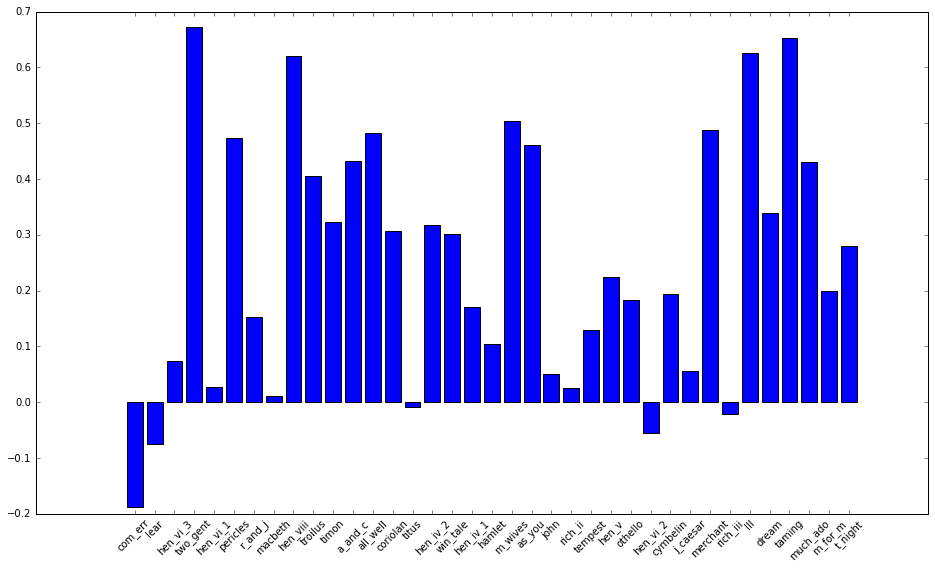

In [5]:

plt.rcParams["figure.figsize"] = (16,9)

plt.bar(range(len(awv)), awv.values(), align='center', )

plt.xticks(range(len(awv)), list(awv.keys()))
ax = plt.axes()
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
plt.show()

In [46]:

from_character = {}
speaker = ''
previous_speaker = ''

# We'll look at character interactions in Hamlet
dfp = df[df.Play=='hamlet']


# Iterate through all Utterances
for i, r in dfp.iterrows():

    # Determine who is speaking
    speaker = r['Speaker']

    # Only calculate if someone spoke before
    if len(previous_speaker) > 0:
        # Get the list of speakers that this speaker has spoken to
        if speaker in from_character:
            to_character = from_character[speaker]
        else:
            to_character = {}
            from_character[speaker] = to_character

        # Get the running total of sentiment valence so far and add the new valence
        if previous_speaker in to_character:
            to_character[previous_speaker] += r['afinn']
        else:
            to_character[previous_speaker] = r['afinn']

    # The current speaker will become the previous speaker for the next utterance
    previous_speaker = speaker
        

In [48]:
# Print out Hamlet's Sentiment Valence Sum 
from IPython.display import display, HTML
df_print = pd.DataFrame.from_dict(from_character['HAMLET'], orient="index")
df_print.sort_values(0,inplace=True, ascending=False)
display(df_print)


,0
QUEEN GERTRUDE,37.0
GUILDENSTERN,27.0
HORATIO,21.0
LORD POLONIUS,20.0
First Player,16.0
ROSENCRANTZ,10.0
OPHELIA,9.0
MARCELLUS,8.0
Ghost,7.0
Captain,7.0
